In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random
import os
import shutil

In [2]:
one = plt.imread('usps_1.jpg')
two = plt.imread('usps_2.jpg')
three = plt.imread('usps_3.jpg')
four = plt.imread('usps_4.jpg')
five = plt.imread('usps_5.jpg')

In [3]:
# CONSTANTS:
DIMENSION = 16
VEC_LEN = 256
SAMPLE_COUNT = 1100
K = 5

In [4]:
def show(img):
    plt.imshow(img, cmap='gray')

In [5]:
def sub_pic_list(total):
    result = []
    r = (int) (total.shape[0] / DIMENSION)
    c = (int) (total.shape[1] / DIMENSION)
    
    for i in range(r):
        for j in range(c):
            if i > 11 and j == (c - 1):
                break
            result.append(sub_pic(i, j, total))
    
    return result

def sub_pic(i, j, total):
    si = i * DIMENSION
    ei = (i + 1) * DIMENSION
    sj = j * DIMENSION
    ej = (j + 1) * DIMENSION
    
    return total[si:ei, sj:ej]


In [6]:
ls1 = sub_pic_list(one)
ls2 = sub_pic_list(two)
ls3 = sub_pic_list(three)
ls4 = sub_pic_list(four)
ls5 = sub_pic_list(five)

In [7]:
def flat_members(ls : np.ndarray):
    return np.array([pic.flatten() for pic in ls])

In [8]:
ls1 = flat_members(ls1)
ls2 = flat_members(ls2)
ls3 = flat_members(ls3)
ls4 = flat_members(ls4)
ls5 = flat_members(ls5)
data = np.vstack((ls1, ls2, ls3, ls4, ls5))
np.random.shuffle(data)

In [9]:
assert ls5.shape == (SAMPLE_COUNT, VEC_LEN)
assert data.shape == (5 * SAMPLE_COUNT, VEC_LEN)

In [10]:
def init_centers(k) -> np.ndarray:
    centers = []
    for i in range(k):
        rand_point = [pixel_rand() for i in range(VEC_LEN)]
        centers.append(rand_point)
    return np.array(centers)

def init_centers2(k):
    centers = []
    for i in range(k):
        rand = random.randrange(0, len(data))
        rand_point = data[rand]
        centers.append(rand_point)
    return np.array(centers)


def pixel_rand():
        return random.randrange(0, 256)

In [11]:
class Group:
    def __init__(self, center):
        self.center = center
        self.members = []
        self.sz_hist = []
            
    def dis(self, vec: np.ndarray) -> float:
        temp = vec - self.center
        sum_sq = np.dot(temp.T, temp)
        return np.sqrt(sum_sq)
    
    def add(self, vec):
        self.members.append(vec)
    
    def flush(self):
        self.members = []
        
    def __len__(self):
        return len(self.members)
    
    def move_center(self):
        self.center = np.mean(self.members, axis=0)
        self.sz_hist.append(len(self))
    
    def converge_score(self):
        return abs(self.sz_hist[-1] - self.sz_hist[-2])

In [12]:
centers = init_centers(K)
groups = [Group(cen) for cen in centers]
assert centers.shape == (K, VEC_LEN)

In [13]:
def flush_all():
    for g in groups:
        g.flush()

In [14]:
def assign():
    for vec in data:
        tmp_ls = [(gp, gp.dis(vec)) for gp in groups]
        best_gp = min(tmp_ls, key=lambda tup: tup[1])[0]
        best_gp.add(vec)

#test
flush_all()
assign()
assert sum([len(g) for g in groups]) == 5500
flush_all()

In [15]:
def move_all():
    for g in groups:
        g.move_center()

In [16]:
def cal_conv_score():
    cur_sum = sum([g.converge_score() for g in groups])
    converge_score_hist.append(cur_sum)

# main block

In [17]:
converge_score_hist = []
it = 60
for i in range(it):
    assign()
    if (i > 1):
        cal_conv_score()
    move_all()
    
    if (i != it -1):
        flush_all()

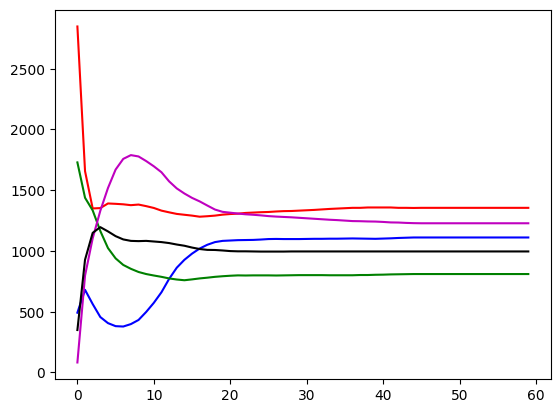

In [18]:
clrs = ['r', 'b', 'g', 'm', 'k', 'r', 'b', 'g', 'm', 'k']
for i in range(len(groups)):
    plt.plot(groups[i].sz_hist, clrs[i])

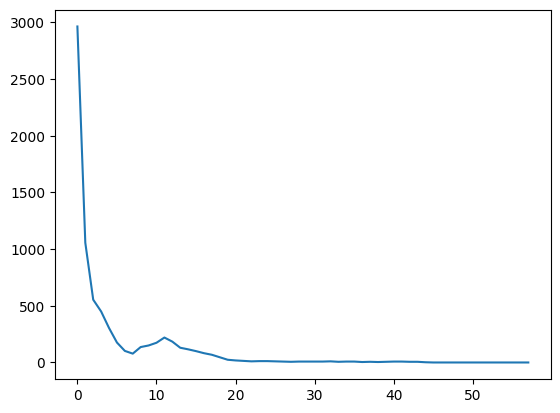

In [19]:
plt.plot(converge_score_hist)

In [20]:
converge_score_hist[-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
if (os.path.isdir('result')):
    shutil.rmtree('result')
os.mkdir('result')

for i in range(len(groups)):
    dr= 'result/' + str(i) + "- size: " +str(len(groups[i].members))
    os.mkdir(dr)
    plt.imsave(dr+'/center.jpeg', groups[i].center.reshape(16,-1), cmap='gray')
    for j in range(20):
        plt.imsave(dr+'/'+str(j)+'.jpeg', groups[i].members[j].reshape(16,-1), cmap='gray')